In [1]:
import numpy
import scipy.sparse
from matplotlib import pyplot
import os
import pickle
from tqdm.notebook import tqdm

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Skip to "ZZ" cells if you're just loading data

In [2]:
import qubit_matmul
import shadow_reconstruction

In [3]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szi = numpy.kron(sz,numpy.eye(2))
siz = numpy.kron(numpy.eye(2),sz)

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [4]:
base_dirs = {
    "/home/sumner/Desktop/NumConsShadows/ladder_single_condensed_L24_M6_open": (24, 6, -0.5),
    "/home/sumner/Desktop/NumConsShadows/ladder_very_single_condensed_L24_M6_open": (24, 6, -2.0),
    "/home/sumner/Desktop/NumConsShadows/ladder_pair_condensed_L24_M6_open": (24, 6, -0.05),
}

In [5]:
data = {}

for k, (l, m, j) in base_dirs.items():
    gs = None
    all_samples = []
    for bb, _, ff in os.walk(k):
        for f in ff:
            filename = os.path.join(bb,f)
            if f.endswith('.data'):
                samples = shadow_reconstruction.Samples.load_from(filename)
                all_samples.append(samples)
            elif gs is None and f.endswith(".npz"):
                gs = numpy.load(filename)['gs']
    acc = all_samples[0]
    for s in all_samples[1:]:
        acc.add_from(s)
    # acc = acc.subset(100_000)
    print("Samples: {}".format(acc.num_samples()))
    data[k] = (l,j,m,acc,gs)

Samples: 8000000
Samples: 8000000
Samples: 8000000


In [6]:
def make_single_rail_data(data, letter_a='Z', letter_b='Z', sparse_fn=make_zz, inversion_by_parts=False):
    plot_data = []
    for (l, j, m, super_samples, gs) in data.values():
        # Enumerate states
        print("Enumerating states...", end='', flush=True)
        num_sector_states = numpy.array(shadow_reconstruction.number_sector_states(l, m))
        print("done", flush=True)
        
        samples = super_samples # Subset if desired
        raw_data = []
        recon_data = []
        recon_data_std = []
        truth_data = []

        recon = shadow_reconstruction.Reconstruction()
        if inversion_by_parts:
            recon.use_inversion_by_parts_estimator()
        for r in range(1,l//2):
            print(f"Getting {letter_a}{letter_b}({r}) matrix...", end='', flush=True)
            corr_check = sparse_fn(0,2*r).get_sparse(l,restrict_rows=num_sector_states, reindex=True)
            print("done", flush=True)
            
            print("Getting ground truth...", end='', flush=True)
            ground_truth = gs @ (corr_check @ gs)            
            truth_data.append(ground_truth)
            print("done", flush=True)

            print("Reconstructing result...", end='', flush=True)
            string = ['I'] * l
            string[0] = letter_a
            string[2*r] = letter_b
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            raw_data.append(estimates)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
            print("done", flush=True)
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        plot_data.append((l,j,truth_data, recon_data, recon_data_std, raw_data))
    return plot_data

def make_double_rail_data(data, letter_a='+', letter_b='+',letter_c='-', letter_d='-', sparse_fn=make_pmpm, inversion_by_parts=False):
    plot_data = []
    for (l, j, m, super_samples, gs) in data.values():
        # Enumerate states
        print("Enumerating states...", end='', flush=True)
        num_sector_states = numpy.array(shadow_reconstruction.number_sector_states(l, m))
        print("done", flush=True)
        
        samples = super_samples # Subset if desired
        raw_data = []
        recon_data = []
        recon_data_std = []
        truth_data = []

        recon = shadow_reconstruction.Reconstruction()
        if inversion_by_parts:
            recon.use_inversion_by_parts_estimator()
        for r in range(1,l//2):
            print(f"Getting {letter_a}{letter_b}{letter_c}{letter_d}({r}) matrix...", end='', flush=True)
            corr_check = sparse_fn(0,2*r,1,2*r+1).get_sparse(l,restrict_rows=num_sector_states, reindex=True)
            print("done", flush=True)
            
            print("Getting ground truth...", end='', flush=True)
            ground_truth = gs @ (corr_check @ gs)            
            truth_data.append(ground_truth)
            print("done", flush=True)

            print("Reconstructing result...", end='', flush=True)
            string = ['I'] * l
            string[0] = letter_a
            string[1] = letter_b
            string[2*r] = letter_c
            string[2*r + 1] = letter_d
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            raw_data.append(estimates)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
            print("done", flush=True)
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        plot_data.append((l,j,truth_data, recon_data, recon_data_std, raw_data))
    return plot_data

# ZZ

In [7]:
# if not os.path.exists('ladder_zzplot_data.pickle'):
#     zzplot_data = make_single_rail_data(data, letter_a='Z', letter_b='Z', sparse_fn=make_zz)
    
#     with open('ladder_zzplot_data.pickle', 'wb') as w:
#         pickle.dump(zzplot_data, w)
# else:
#     with open('ladder_zzplot_data.pickle', 'rb') as f:
#         zzplot_data = pickle.load(f)

In [8]:
# for (l,j,truth_data, recon_data, recon_data_std, _) in zzplot_data:
#     pyplot.plot(range(1,l), abs(truth_data), alpha=0.3)
#     pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, fmt='x')
#     pyplot.title(r'$J_z={:.1f}$'.format(j))
#     pyplot.ylabel(r'$|\langle \sigma^{z}_0 \sigma^{z}_r \rangle|$')
#     pyplot.xlabel('$r$')
#     pyplot.grid()
#     pyplot.xlim([0,16])
#     pyplot.savefig('zzj{:.3f}.jpeg'.format(j))
#     pyplot.show()

In [9]:
# for (l,j,truth_data, recon_data, recon_data_std, _) in zzplot_data:
#     near_zero = abs(j - 0.0) < 1e-6
#     near_two = abs(j - (-2.0)) < 1e-6
#     if near_zero or near_two:
#         if near_zero:
#             c = 'blue'
#         else:
#             c = 'red'
#         pyplot.plot(range(1,l), abs(truth_data), '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
#         pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, c=c, fmt='.', capsize=5)
# pyplot.ylabel(r'$|\langle Z_0 Z_r \rangle|$')
# pyplot.xlabel('$r$')
# pyplot.grid()
# pyplot.xlim([0,16])
# pyplot.legend(loc='upper right')
# pyplot.savefig('zzj_comp.pdf'.format(j))
# pyplot.show()

# PM

In [8]:
# if not os.path.exists('ladder_pmplot_data.pickle'):
#     plot_data =  make_single_rail_data(data, letter_a='+', letter_b='-', sparse_fn=make_pm)
    
#     with open('ladder_pmplot_data.pickle', 'wb') as w:
#         pickle.dump(plot_data, w)
# else:
#     with open('ladder_pmplot_data.pickle', 'rb') as f:
#         plot_data = pickle.load(f)
plot_data =  make_single_rail_data(data, letter_a='+', letter_b='-', sparse_fn=make_pm)

Enumerating states...done
Getting +-(1) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(2) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(3) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(4) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(5) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(6) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(7) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(8) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(9) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(10) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting +-(11) matrix...done
Getting ground truth...done
Reconstructing result...done
Enumerating states...done
Getting +-(

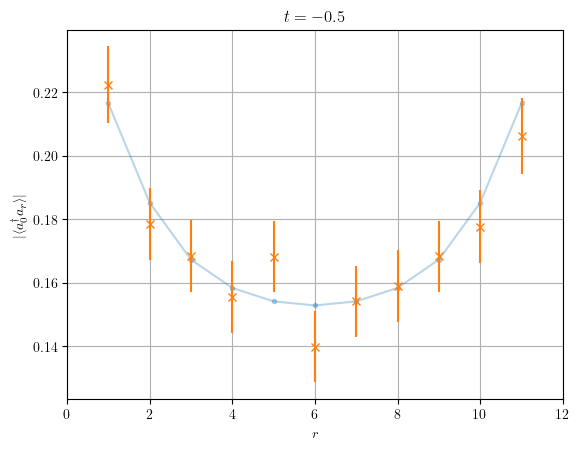

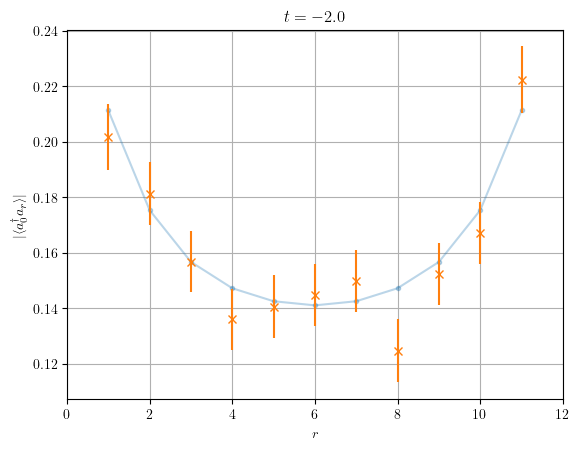

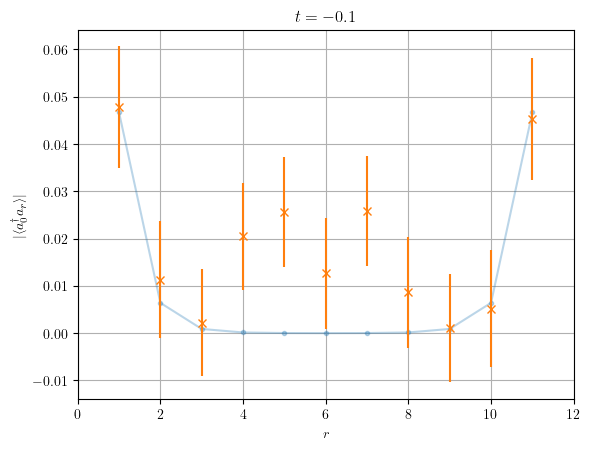

In [11]:
for (l,j,truth_data, recon_data, recon_data_std, _) in plot_data:
    pyplot.plot(range(1,l//2), abs(truth_data), '.-', alpha=0.3)
    pyplot.errorbar(range(1,l//2), abs(recon_data), yerr=recon_data_std, fmt='x')
    pyplot.title(r'$t={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle a^{\dagger}_0 a_r \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.xlim([0,24//2])
    pyplot.grid()
    pyplot.savefig('pmt{:.3f}.pdf'.format(j))
    pyplot.show()

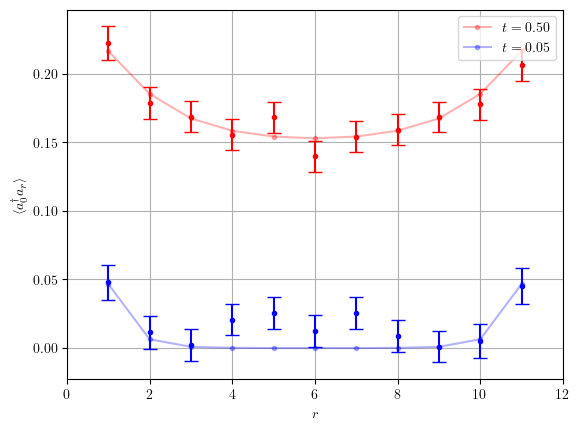

In [12]:
for (l,j,truth_data, recon_data, recon_data_std, _) in plot_data:
    near_zero = abs(j + 0.05) < 1e-6
    near_two = abs(j + 0.5) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        pyplot.plot(range(1,l//2), abs(truth_data).real, '.-', alpha=0.3, c=c, label=r'$t={:.2f}$'.format(-j))
        pyplot.errorbar(range(1,l//2), abs(recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)
pyplot.ylabel(r'$\langle a^{\dagger}_0 a_r \rangle$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,l//2])
pyplot.legend(loc='upper right')
pyplot.savefig('pmj_comp.pdf'.format(j))
pyplot.show()

# PPMM

In [13]:
# if not os.path.exists('pmpmplot_data.pickle'):
#     pmpmplot_data = make_double_rail_data(data, letter_a='+', letter_b='+', letter_c='-', letter_d='-', sparse_fn=make_pmpm)
#     with open('pmpmplot_data.pickle', 'wb') as w:
#         pickle.dump(pmpmplot_data, w)
# else:
#     with open('pmpmplot_data.pickle', 'rb') as f:
#         pmpmplot_data = pickle.load(f)


sub_data = {
    k: (l,j,m,acc.subset(100_000),gs) 
    for k, (l,j,m,acc,gs) in data.items()
}

pmpmplot_data = make_double_rail_data(sub_data, letter_a='+', letter_b='+', letter_c='-', letter_d='-', sparse_fn=make_pmpm)

Enumerating states...done
Getting ++--(1) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(2) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(3) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(4) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(5) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(6) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(7) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(8) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(9) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(10) matrix...done
Getting ground truth...done
Reconstructing result...done
Getting ++--(11) matrix...done
Getting ground truth...done
Reconstructing result...done
Enumerating sta

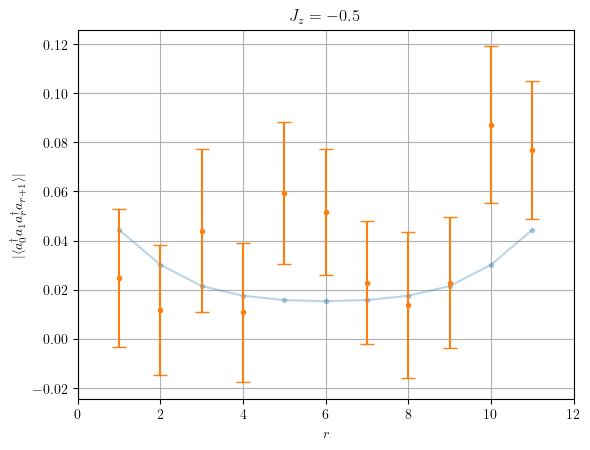

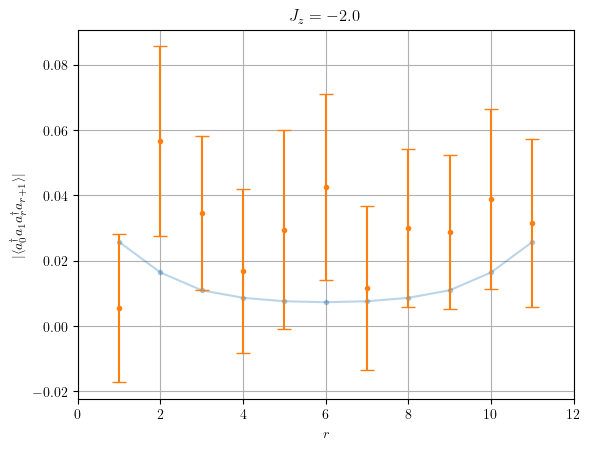

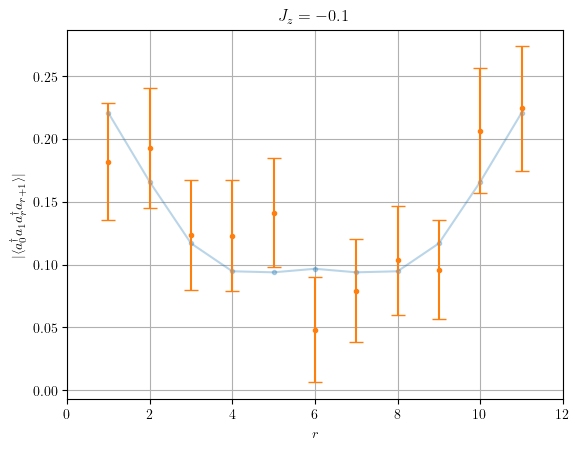

In [14]:
for (l,j,truth_data, recon_data, recon_data_std, _) in pmpmplot_data:
    pyplot.plot(range(1,l//2), abs(truth_data), '.-', alpha=0.3)
    pyplot.errorbar(range(1,l//2), abs(recon_data), yerr=recon_data_std, fmt='.', capsize=5)
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle a^{\dagger}_0 a_1 a^{\dagger}_r a_{r+1} \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.grid()
    pyplot.xlim([0,l//2])
    pyplot.savefig('pmpmj{:.3f}.pdf'.format(j))
    pyplot.show()

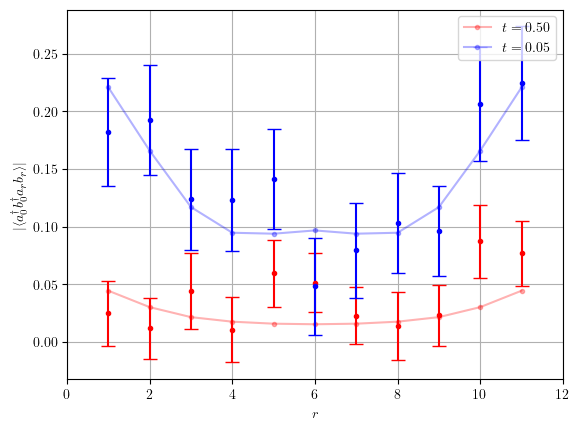

In [15]:
for (l,j,truth_data, recon_data, recon_data_std, _) in pmpmplot_data:
    near_zero = abs(j + 0.05) < 1e-6
    near_two = abs(j + 0.5) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        pyplot.plot(range(1,l//2), abs(truth_data), '.-', alpha=0.3, c=c, label=r'$t={:.2f}$'.format(-j))
        pyplot.errorbar(range(1,l//2), abs(recon_data), yerr=recon_data_std, c=c, fmt='.', capsize=5)

pyplot.ylabel(r'$|\langle a^{\dagger}_0 b^{\dagger}_0 a_r b_r \rangle|$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,l//2])
pyplot.legend(loc='upper right')
pyplot.savefig('ppmmj_comp.pdf'.format(j))
pyplot.show()

# Merge and Style

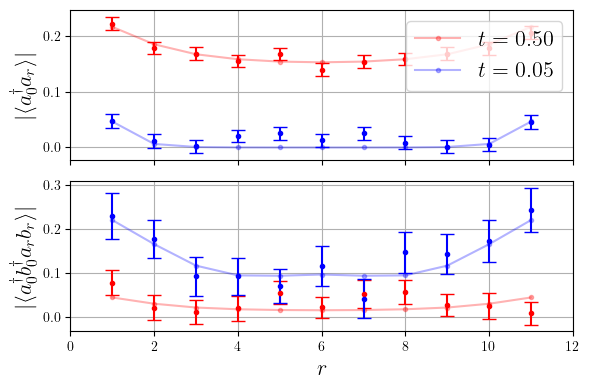

In [16]:
fig, axs = pyplot.subplots(2, figsize=(6,4))

for (l,j,truth_data, recon_data, recon_data_std, _) in plot_data:
    near_zero = abs(j + 0.05) < 1e-6
    near_two = abs(j + 0.5) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        axs[0].plot(range(1,l//2), abs(truth_data).real, '.-', alpha=0.3, c=c, label=r'$t={:.2f}$'.format(-j))
        axs[0].errorbar(range(1,l//2), abs(recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)
axs[0].set_ylabel(r'$|\langle a^{\dagger}_0 a_r \rangle|$', fontsize=16)
axs[0].grid()
axs[0].set_xlim([0,l//2])
axs[0].xaxis.set_ticklabels([])
axs[0].legend(loc='upper right', fontsize=16)

for (l,j,truth_data, recon_data, recon_data_std, _) in pmpmplot_data:
    near_zero = abs(j + 0.05) < 1e-6
    near_two = abs(j + 0.5) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        axs[1].plot(range(1,l//2), abs(truth_data), '.-', alpha=0.3, c=c, label=r'$t={:.2f}$'.format(-j))
        axs[1].errorbar(range(1,l//2), abs(recon_data), yerr=recon_data_std, c=c, fmt='.', capsize=5)

axs[1].set_ylabel(r'$|\langle a^{\dagger}_0 b^{\dagger}_0 a_r b_r \rangle|$', fontsize=16)
axs[1].set_xlabel('$r$', fontsize=16)
axs[1].grid()
axs[1].set_xlim([0,l//2])
fig.tight_layout()
pyplot.savefig('comp_comp.pdf'.format(j))
pyplot.show()

# Translational Symmetry

In [9]:
def trans_make_single_rail_data(data, letter_a='+', letter_b='-', sparse_fn=make_pm, inversion_by_parts=False):
    plot_data = []
    for (l, jj, m, samples, gs) in data.values():
        num_sector_states = numpy.array(shadow_reconstruction.number_sector_states(l, m))
        recon = shadow_reconstruction.Reconstruction()
        if inversion_by_parts:
            recon.use_inversion_by_parts_estimator()
        corr_dict = {}
        for i in range(0,l//2):
            for j in range(i+1,l//2):
                corr_check = sparse_fn(2*i,2*j).get_sparse(l,restrict_rows=num_sector_states, reindex=True)

                ground_truth = gs @ (corr_check @ gs)
                string = ['I'] * l
                string[2*i] = letter_a
                string[2*j] = letter_b
                string = ''.join(string)
                estimates = recon.estimate_string_for_each_sample(string, samples)
                corr_dict[(i,j)] = (ground_truth, estimates.mean(), estimates.var(), len(estimates))
        plot_data.append((l,jj,corr_dict))
    return plot_data

def trans_make_double_rail_data(data, letter_a='+', letter_b='+',letter_c='-', letter_d='-', sparse_fn=make_pmpm, inversion_by_parts=False):
    plot_data = []
    for (l, jj, m, samples, gs) in data.values():
        num_sector_states = numpy.array(shadow_reconstruction.number_sector_states(l, m))
        recon = shadow_reconstruction.Reconstruction()   
        if inversion_by_parts:
            recon.use_inversion_by_parts_estimator()
        corr_dict = {}
        for i in range(0,l//2):
            for j in range(i+1,l//2):
                corr_check = sparse_fn(2*i,2*j,2*i+1,2*j+1).get_sparse(l,restrict_rows=num_sector_states, reindex=True)

                ground_truth = gs @ (corr_check @ gs)
                string = ['I'] * l
                string[2*i] = letter_a
                string[2*i+1] = letter_b
                string[2*j] = letter_c
                string[2*j+1] = letter_d
                string = ''.join(string)
                estimates = recon.estimate_string_for_each_sample(string, samples)
                corr_dict[(i,j)] = (ground_truth, estimates.mean(), estimates.var(), len(estimates))
        plot_data.append((l,jj,corr_dict))
    return plot_data

To get actual error bars, subsample and run multiple times

In [40]:
n_subsamples = 20_000
n_trials = 50

single_t = -0.05
pair_t = -0.5
dt = 1e-6

In [43]:
trials_plotdata = []
trials_ppmmplot_data = []
for _ in tqdm(range(n_trials)):
    sub_data = {
        k: (l,j,m,acc.subset(n_subsamples),gs) 
        for k, (l,j,m,acc,gs) in data.items()
        if abs(j - single_t) < dt or abs(j - pair_t) < dt
    }
    plot_data = trans_make_single_rail_data(sub_data)
    trials_plotdata.append(plot_data)
    
    ppmmplot_data = trans_make_double_rail_data(sub_data)
    trials_ppmmplot_data.append(ppmmplot_data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
def get_near(plot_data, t, dt=1e-6):
    for (l,j,cs) in plot_data:
        if abs(j - t) < dt:            
            truth = numpy.zeros((l//2 - 1,))
            corrs = numpy.zeros((l//2 - 1,))
            corrs_std = numpy.zeros((l//2 - 1,))
            corrs_counts = numpy.zeros((l//2 - 1,))

            for r in range(1,l//2):
                for i in range(0,l//2):
                    a, b = (i,(i+r)%(l//2))
                    aa = min(a,b)
                    bb = max(a,b)
                    (t, m, v, n) = cs[(aa,bb)]
                    truth[r-1] += t.real * n
                    corrs[r-1] += m.real * n
                    corrs_std[r-1] += v
                    corrs_counts[r-1] += n
            truth = truth/corrs_counts
            corrs = corrs/corrs_counts
            corrs_std = numpy.sqrt(corrs_std/corrs_counts)
            return truth, corrs, corrs_std

trails_plotdata_ptruth = []
trails_plotdata_pcorrs = []
trails_plotdata_struth = []
trails_plotdata_scorrs = []
for plot_data in tqdm(trials_plotdata):
    ptruth, pcorrs, _ = get_near(plot_data, single_t, dt=dt)
    trails_plotdata_ptruth.append(ptruth)
    trails_plotdata_pcorrs.append(pcorrs)
    
    struth, scorrs, _ = get_near(plot_data, pair_t, dt=dt)
    trails_plotdata_struth.append(struth)
    trails_plotdata_scorrs.append(scorrs)
trails_plotdata_ptruth = numpy.array(trails_plotdata_ptruth).mean(axis=0)
trails_plotdata_pcorrs = numpy.array(trails_plotdata_pcorrs)
trails_plotdata_struth = numpy.array(trails_plotdata_struth).mean(axis=0)
trails_plotdata_scorrs = numpy.array(trails_plotdata_scorrs)


trails_pair_ptruth = []
trails_pair_pcorrs = []
trails_pair_struth = []
trails_pair_scorrs = []
for ppmmplot_data in tqdm(trials_ppmmplot_data):
    ptruth, pcorrs, _ = get_pm_near(ppmmplot_data, -0.05)
    trails_pair_ptruth.append(ptruth)
    trails_pair_pcorrs.append(pcorrs)
    
    struth, scorrs, _ = get_pm_near(ppmmplot_data, -0.5)
    trails_pair_struth.append(struth)
    trails_pair_scorrs.append(scorrs)
trails_pair_ptruth = numpy.array(trails_pair_ptruth).mean(axis=0)
trails_pair_pcorrs = numpy.array(trails_pair_pcorrs)
trails_pair_struth = numpy.array(trails_pair_struth).mean(axis=0)
trails_pair_scorrs = numpy.array(trails_pair_scorrs)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
ptruth = trails_plotdata_ptruth
struth = trails_plotdata_struth
pcorrs = trails_plotdata_pcorrs.mean(axis=0)
pcorrsstd = trails_plotdata_pcorrs.std(axis=0)/numpy.sqrt(trails_plotdata_pcorrs.shape[0])
scorrs = trails_plotdata_scorrs.mean(axis=0)
scorrsstd = trails_plotdata_scorrs.std(axis=0)/numpy.sqrt(trails_plotdata_scorrs.shape[0])


pair_ptruth = trails_pair_ptruth
pair_struth = trails_pair_struth
pair_pcorrs = trails_pair_pcorrs.mean(axis=0)
pair_pcorrsstd = trails_pair_pcorrs.std(axis=0)
pair_scorrs = trails_pair_scorrs.mean(axis=0)
pair_scorrsstd = trails_pair_scorrs.std(axis=0)

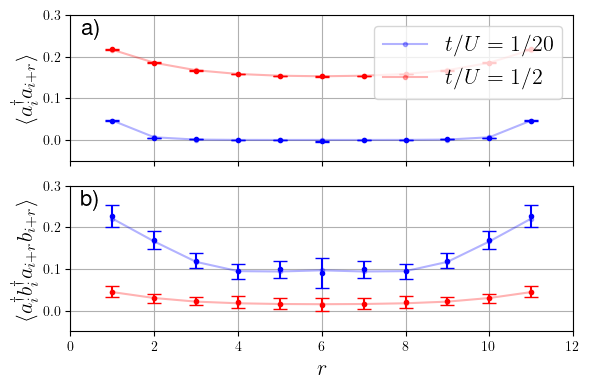

In [49]:
fig, axs = pyplot.subplots(2, figsize=(6,4))


axs[0].plot(range(1,l//2), ptruth, '.-', alpha=0.3, c='blue', label=r'$t/U=1/20$')
axs[0].plot(range(1,l//2), struth, '.-', alpha=0.3, c='red', label=r'$t/U=1/2$')
axs[0].errorbar(range(1,l//2), (pcorrs), yerr=pcorrsstd, c='blue', fmt='.', capsize=5)
axs[0].errorbar(range(1,l//2), (scorrs), yerr=scorrsstd, c='red', fmt='.', capsize=5)

axs[0].set_ylabel(r'$\langle a^{\dagger}_i a_{i+r} \rangle$', fontsize=16)
axs[0].grid()
axs[0].set_xlim([0,l//2])
axs[0].set_ylim([-0.05,0.3])
axs[0].xaxis.set_ticklabels([])
axs[0].legend(loc='upper right', fontsize=16)
axs[0].text(0.25,0.25,'a)',fontsize=16)

axs[1].plot(range(1,l//2), pair_ptruth, '.-', alpha=0.3, c='blue', label=r'$t/U=1/20$')
axs[1].plot(range(1,l//2), pair_struth, '.-', alpha=0.3, c='red', label=r'$t/U=1/2$')
axs[1].errorbar(range(1,l//2), (pair_pcorrs), yerr=pair_pcorrsstd, c='blue', fmt='.', capsize=5)
axs[1].errorbar(range(1,l//2), (pair_scorrs), yerr=pair_scorrsstd, c='red', fmt='.', capsize=5)

axs[1].set_ylabel(r'$\langle a^{\dagger}_i b^{\dagger}_i a_{i+r} b_{i+r} \rangle$', fontsize=16)
axs[1].set_xlabel('$r$', fontsize=16)
axs[1].grid()
axs[1].set_xlim([0,l//2])
axs[1].set_ylim([-0.05,0.3])
axs[1].text(0.25,0.25,'b)',fontsize=16)
fig.tight_layout()
pyplot.savefig('comp_comp_trans.pdf')
pyplot.show()

# Z strings

In [43]:
%time plotable_a = trans_make_single_rail_data(data, letter_a='Z', letter_b='Z', sparse_fn=make_zz)

CPU times: user 1h 16min 45s, sys: 2min 23s, total: 1h 19min 8s
Wall time: 3min 52s


In [44]:
%time plotable_b = trans_make_single_rail_data(data, letter_a='Z', letter_b='Z', sparse_fn=make_zz, inversion_by_parts=True)

CPU times: user 1min 48s, sys: 4min 8s, total: 5min 57s
Wall time: 39.5 s


In [45]:
_, a_pcorrs, a_pcorrsstd = get_pm_near(plotable_a, -0.5)
b_ptruth, b_pcorrs, b_pcorrsstd = get_pm_near(plotable_b, -0.5)

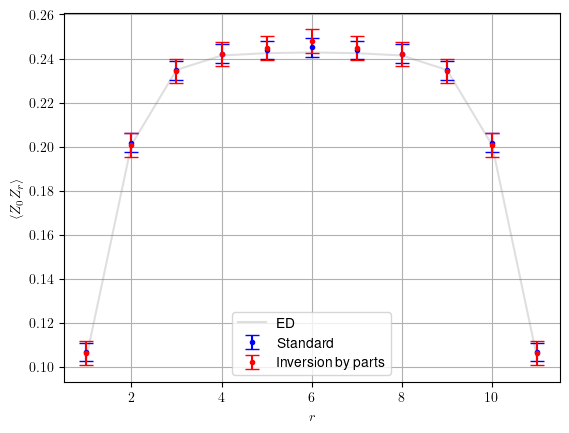

In [46]:
pyplot.plot(range(1,l//2), b_ptruth, c='gray', alpha=0.25, label='ED')
pyplot.errorbar(range(1,l//2), (a_pcorrs), yerr=a_pcorrsstd, c='blue', fmt='.', capsize=5, label='Standard')
pyplot.errorbar(range(1,l//2), (b_pcorrs), yerr=b_pcorrsstd, c='red', fmt='.', capsize=5, label='Inversion by parts')
pyplot.legend()
pyplot.grid()
pyplot.xlabel(r'$r$')
pyplot.ylabel(r'$\langle Z_0 Z_r \rangle$')
pyplot.show()

In [47]:
_, a_pcorrs, a_pcorrsstd = get_pm_near(plotable_a, -0.05)
b_ptruth, b_pcorrs, b_pcorrsstd = get_pm_near(plotable_b, -0.05)

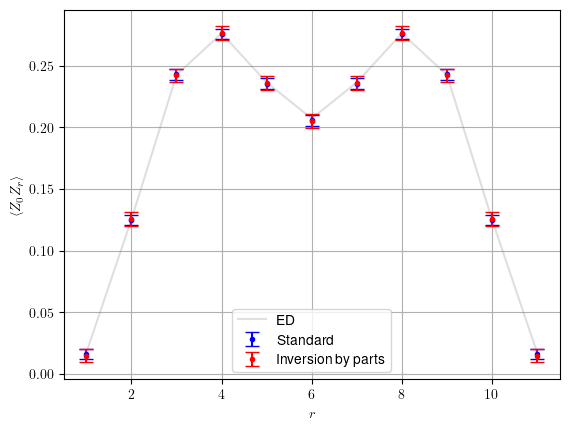

In [48]:
pyplot.plot(range(1,l//2), b_ptruth, c='gray', alpha=0.25, label='ED')
pyplot.errorbar(range(1,l//2), (a_pcorrs), yerr=a_pcorrsstd, c='blue', fmt='.', capsize=5, label='Standard')
pyplot.errorbar(range(1,l//2), (b_pcorrs), yerr=b_pcorrsstd, c='red', fmt='.', capsize=5, label='Inversion by parts')
pyplot.legend()
pyplot.grid()
pyplot.xlabel(r'$r$')
pyplot.ylabel(r'$\langle Z_0 Z_r \rangle$')
pyplot.show()